In [676]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [677]:
test_titanic=pd.read_csv("test.csv")
test_titan=test_titanic.copy()

titanic = pd.read_csv("train.csv")
titan=titanic.copy()

In [678]:
test_titan

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [679]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [680]:
def preprocessing(titan):
    #First second ve third class yolcuların Bulundukları kabinlerin olasılıksal dağılımları
    perfirst = {
        "A": .11,
        "B": .32,
        "C": .42,
        "D": .15,
    }
    persecond = {
        "D": .23,
        "E": .39,
        "F": .38,
    }
    perthird = {
        "G": 1,
    }
    height= {
        "A": 10,
        "B": 20,
        "C": 30,
        "D": 40,
        "E": 50,
        "F": 60,
        "G": 70,
        "T": 10,
    }

    olas=[perfirst,persecond,perthird]
        
    ##isimdeki kelime sayısını buluyor, ve yeni bir column olarak data sete girişini yapıyor
    titan["Alphabet_Num"] = titan["Name"].str.len()

    ##boş yaşları ortalamalarla değiştiriyor
    ort = np.mean(titan["Age"])
    titan["Age"] = titan["Age"].fillna(ort)

    ## Cabin Harflerini Belirliyor
    titan["Cabin"]=titan["Cabin"].fillna("0")
    m = titan["Cabin"].shape[0]
    for i in range(m): 
        for c in titan["Cabin"][i]:
            if c.isalpha():
                titan["Cabin"][i]=c

    #İnternetten aldığım verilere göre 1st 2nd 3rd seviye yolcuların odalarda olma ihtimaline göre dağılım
    #, cabini belirtilmemiş yolcular için olasılıksal ihtimale göre dolduruyor
    class_num=len(pd.unique(titan["Pclass"]))
    
    for k in range(class_num):

        total_each_cabin= titan.loc[(titan["Pclass"]==k+1) & (titan["Cabin"]=="0")].shape[0]
        cabin_left=total_each_cabin

        for i,j in olas[k].items():

            sample=int(np.round(total_each_cabin*j))

            
            if cabin_left < sample:
                titan.iloc[titan.loc[(titan["Pclass"]==k+1) & (titan["Cabin"]=="0")].sample(cabin_left).index.values,list(titan.columns).index("Cabin")]=i
                
            else:
                cabin_left= cabin_left-sample
                titan.iloc[titan.loc[(titan["Pclass"]==k+1) & (titan["Cabin"]=="0")].sample(sample).index.values,list(titan.columns).index("Cabin")]=i
                

    ##Height adında bi bölüm oluşturup, geminin en yukarısından en aşağısını numaralandırıyor
    titan["height"]=np.NaN
    for i,j in height.items():
        tmp=titan.loc[titan["Cabin"]==i]
        tmp["height"]= tmp["height"].fillna(j)
        titan.loc[titan["Cabin"]==i]=tmp

    #Yeni bir Feature
    titan["heightsqrd"]=titan["height"]**2

    #Cabinleri ve Sexleri ayırma 
    titan = pd.get_dummies(titan, columns=["Sex"])
    titan = pd.get_dummies(titan, columns=["Cabin"])

    return titan


In [681]:
titan =preprocessing(titan)
test_titan =preprocessing(test_titan)

C:\Users\musta\AppData\Local\Temp\ipykernel_2564\2993824144.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titan["Cabin"][i]=c
C:\Users\musta\AppData\Local\Temp\ipykernel_2564\2993824144.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titan["Cabin"][i]=c
C:\Users\musta\AppData\Local\Temp\ipykernel_2564\2993824144.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titan["Cabin"][i]=c
C:\Users\musta\AppData\Local\Temp\ipyker

In [682]:
test_titan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Name          418 non-null    object 
 3   Age           418 non-null    float64
 4   SibSp         418 non-null    int64  
 5   Parch         418 non-null    int64  
 6   Ticket        418 non-null    object 
 7   Fare          417 non-null    float64
 8   Embarked      418 non-null    object 
 9   Alphabet_Num  418 non-null    int64  
 10  height        418 non-null    float64
 11  heightsqrd    418 non-null    float64
 12  Sex_female    418 non-null    bool   
 13  Sex_male      418 non-null    bool   
 14  Cabin_A       418 non-null    bool   
 15  Cabin_B       418 non-null    bool   
 16  Cabin_C       418 non-null    bool   
 17  Cabin_D       418 non-null    bool   
 18  Cabin_E       418 non-null    

In [683]:
test_titan["Fare"]=test_titan["Fare"].fillna(np.mean(test_titan["Fare"]))

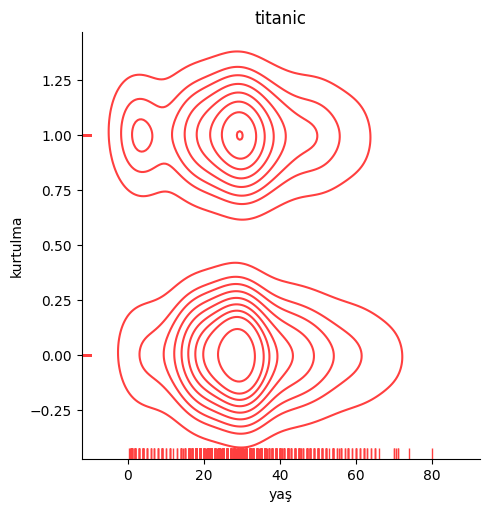

In [684]:
sns.displot(titan, x = "Age", y = "Survived", kind = "kde", rug = True, color = "#FF3F3F")
plt.ylabel("kurtulma")
plt.xlabel("yaş")
plt.title("titanic")
plt.show()

In [685]:
##Gereksiz verilerden kurtulma
y=titan[["Survived"]].values
y=y.reshape(-1,)
X=titan.drop(["PassengerId","Name","Ticket","Embarked","Cabin_T","Survived"], axis = 1)

X_test=test_titan.drop(["PassengerId","Name","Ticket","Embarked"], axis = 1)



In [686]:
print(X_test.columns,"\n",
X.columns)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Alphabet_Num', 'height',
       'heightsqrd', 'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G'],
      dtype='object') 
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Alphabet_Num', 'height',
       'heightsqrd', 'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G'],
      dtype='object')


In [687]:
scaler_poly = StandardScaler()
X = scaler_poly.fit_transform(X)
X_test = scaler_poly.fit_transform(X_test)

In [688]:
titan_lr.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Alphabet_Num,height,heightsqrd,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
Survived,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,0.332350,-0.300739,-0.317104,0.543351,-0.543351,0.027271,0.174688,0.122513,0.082150,0.124838,0.079289,-0.331600
Pclass,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,-0.220001,0.927723,0.951597,-0.131900,0.131900,-0.231175,-0.420820,-0.478244,-0.280740,-0.220341,-0.104588,0.906346
Age,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,0.031533,-0.315322,-0.319970,-0.084153,0.084153,0.116709,0.115297,0.132579,0.161607,0.075030,-0.057521,-0.276517
SibSp,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,0.165019,0.086304,0.088223,0.114631,-0.114631,-0.048901,-0.038117,0.000917,-0.042497,-0.028443,-0.036081,0.095750
Parch,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,0.252282,0.022032,0.020558,0.245489,-0.245489,-0.050632,0.022817,0.004982,-0.028414,-0.016747,0.028244,0.012718
Fare,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,0.155832,-0.549261,-0.536335,0.182333,-0.182333,0.036319,0.451034,0.352620,0.034930,-0.013084,-0.070586,-0.408437
Alphabet_Num,0.332350,-0.220001,0.031533,0.165019,0.252282,0.155832,1.000000,-0.193677,-0.199041,0.448759,-0.448759,0.065879,0.071493,0.120261,0.019997,0.051374,0.070365,-0.205099
height,-0.300739,0.927723,-0.315322,0.086304,0.022032,-0.549261,-0.193677,1.000000,0.988118,-0.106842,0.106842,-0.377273,-0.538177,-0.442743,-0.277793,-0.121567,0.062016,0.834910
heightsqrd,-0.317104,0.951597,-0.319970,0.088223,0.020558,-0.536335,-0.199041,0.988118,1.000000,-0.121330,0.121330,-0.289649,-0.480569,-0.457699,-0.338654,-0.202230,0.019334,0.896364
Sex_female,0.543351,-0.131900,-0.084153,0.114631,0.245489,0.182333,0.448759,-0.106842,-0.121330,1.000000,-1.000000,-0.076367,0.101762,0.052287,0.020879,0.083062,0.031259,-0.138116


In [689]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=32)

x_train = x_train
x_test = x_test
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)
titan.sample(1)

x_train:  (757, 17)
x_test:  (134, 17)
y_train:  (757,)
y_test:  (134,)


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
433,434,0,3,"Kallio, Mr. Nikolai Erland",17.0,0,0,STON/O 2. 3101274,7.125,S,...,False,True,False,False,False,False,False,False,True,False


***Logistic Regression***

In [690]:
#X test ve X'in parametreleri hazırlanıyor, feature scale'leri yapılıyor
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

LogisticRegression()

In [691]:
##Prediction Yapılıyor

y_pred_lr = lr_model.predict(x_test)

print("Prediction on training set:", y_pred)
print("Accuracy on training set:", lr_model.score(x_test, y_test))


Prediction on training set: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0
 0 1 1 1 1 1 0 1 0 0 0]
Accuracy on training set: 0.8208955223880597


In [692]:
y_pred=lr_model.predict(X_test)

In [693]:
realtest=pd.read_csv("gender_submission.csv")
result = pd.merge(realtest, test_titan[["PassengerId"]], on='PassengerId', how="inner")
np.abs(result["Survived"]-y_pred).sum()

30

***K-Nearest-Neighbors***

In [694]:
from sklearn.model_selection import train_test_split

In [695]:
from sklearn.neighbors import KNeighborsClassifier

In [696]:
score_list = []
for each in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=each)
    knn.fit(x_train, y_train)
    score_list.append(knn.score(x_test, y_test))

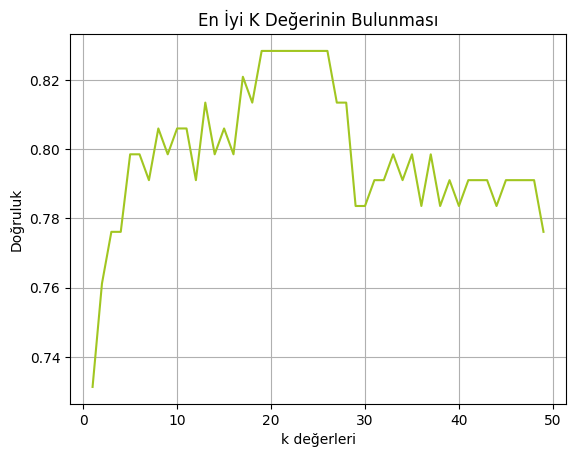

In [697]:
plt.plot(range(1,50), score_list, color = "#a1c621")
plt.xlabel("k değerleri")
plt.ylabel("Doğruluk")
plt.title("En İyi K Değerinin Bulunması")
plt.grid(True)
plt.show()

In [698]:
knn20 = KNeighborsClassifier(n_neighbors=20)
knn20.fit(x_train, y_train)
knn20.score(x_test, y_test)

0.8283582089552238

In [699]:
y_pred_knn=knn20.predict(X_test)

In [700]:
realtest=pd.read_csv("gender_submission.csv")
result = pd.merge(realtest, test_titan[["PassengerId"]], on='PassengerId', how="inner")
np.abs(result["Survived"]-y_pred_knn).sum()

28

***Support Vector Machine***

In [701]:
from sklearn.svm import SVC

In [702]:
svm = SVC(random_state=1)
svm.fit(x_train, y_train)

SVC(random_state=1)

In [703]:
svm.score(x_test, y_test)

0.8283582089552238

In [704]:
y_pred_svm=svm.predict(X_test)

In [705]:
realtest=pd.read_csv("gender_submission.csv")
result = pd.merge(realtest, test_titan[["PassengerId"]], on='PassengerId', how="inner")
np.abs(result["Survived"]-y_pred_svm).sum()

17

***Decision Tree***

In [706]:
from sklearn.tree import DecisionTreeClassifier

In [707]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [708]:
dt.score(x_test, y_test)

0.7388059701492538

In [709]:
y_pred_dt= dt.predict(X_test)

In [710]:
realtest=pd.read_csv("gender_submission.csv")
result = pd.merge(realtest, test_titan[["PassengerId"]], on='PassengerId', how="inner")
np.abs(result["Survived"]-y_pred_dt).sum()

92

#######################################################################################################################################################################################################

**_With Deep Learning_** : Even though data set is small, wanted to try out with deep learning

In [711]:
y=y.reshape(891,1)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [712]:
def deeplearn(X,y,epochs):
    model = Sequential(
        [ 
            Dense(25, activation = 'relu'),
            Dense(50, activation = 'relu'),
            Dense(10, activation = 'relu'),
            Dense(1, activation = 'sigmoid')    
        ]
    )
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(0.001),
    )

    model.fit(
        X, y,
        epochs=epochs
    )
    return model
        

In [713]:
epocs=[10,20,30,40,50,60]
models=[]
preds=[]
loss=[]

In [714]:
for i in range(len(epocs)):
    model = deeplearn(X,y,epocs[i])
    predictions = model.predict(X_test)
    yhat = np.zeros_like(predictions)
    m , n=predictions.shape
    yhat=yhat.reshape(m,)
    for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            yhat[i] = 1
        else:
            yhat[i] = 0
    los=(np.abs(result["Survived"]-yhat)).sum()

    models.append(model)
    preds.append(predictions)
    loss.append(los)

Epoch 1/10


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6976
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5950 
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4891 
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4713 
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4827 
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4403 
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4293 
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4107 
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4357
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4044
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7241 
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5787 
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4976 
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4561 
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

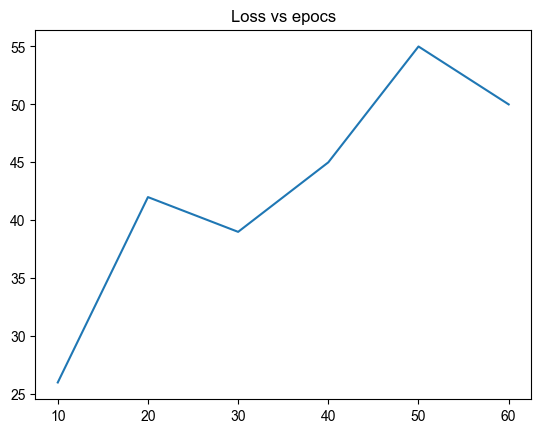

In [715]:
sns.lineplot(x = epocs, y = loss)
plt.title("Loss vs epocs")
sns.set_style("ticks")
plt.show()

In [716]:
loss ##10-30 epocs is optimum if deep learning is used

[26.0, 42.0, 39.0, 45.0, 55.0, 50.0]

***#####################################################################################################################################################################################################################***

In [717]:
## elimizdeki en iyi sonuç support vector machine'den olduğu için cevap olarak onu kullanıyoruz
data = {'PassengerId': result["PassengerId"].values,
        'Survived': y_pred_svm,
        }
Final = pd.DataFrame(data)

Final.to_csv("Final.csv",index=False)